In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import statistics
import random
import math

# Hamming weights of numbers 0-15
HW = [0,1,1,2,1,2,2,3,1,2,2,3,2,3,3,4]

# PRESENT Sbox
S = [12,5,6,11,9,0,10,13,3,14,15,8,4,7,1,2]

profiling_trace_folder = 'random_dataset/'
attack_trace_folder = 'random_pt_dataset/'

In [2]:
#Loading data from the random dataset
file_no_rk = 10000
traces_rk = []
plaintexts_rk = []
keys_rk = []

for i in range(file_no_rk):
    with open(profiling_trace_folder + 'trace_'+str(i)+'.txt') as f:
        lines = f.read().splitlines()
        traces_rk.append(lines)

with open(profiling_trace_folder + 'plaintexts.txt') as f:
    plaintexts_rk = f.read().splitlines()

with open(profiling_trace_folder + 'keys.txt') as f:
    keys_rk = f.read().splitlines()

trace_array_rk = np.array(traces_rk)
trace_array_rk = trace_array_rk.astype(float)

#number of time samples in one trace
N_rk = 5000

In [3]:
sbox_outputs = [[0 for i in range(16)] for j in range(file_no_rk)]
#compute the intermediate values
for j in range(file_no_rk):
    for i in range(16):
        pt = int(plaintexts_rk[j][15-i],16)#extract the target nibble of the plaintext
        ky = int(keys_rk[j][15-i],16)#extract the target nibble of the first round key
        v = S[ky^pt]#compute the output of the 0th Sbox for this plaintext
        sbox_outputs[j][i] = v

In [4]:
#save data to file for tikz plot
def savetofile(filename,array):
    f = open(filename+".txt", "w")
    f.write("x y\n")
    i = 0
    for i in range(len(array)):
        f.write(str(i)+" "+str(array[i])+"\n")
        i+=1
    f.close()

In [5]:
def highest_tree_points(array):
    array_abs = [abs(a) for a in array]
    ind = np.argpartition(array_abs, -3)[-3:]
    print(ind)
    array_abs = np.array(array_abs)
    print(array_abs[ind])
    return

## Compute SNR and identify POI

In [6]:
#Function for computing SNR, given time sample t, and the choice of signal:
#signal correspond to the exact value of the 0th Sbox output
#ifprint = 1, intermedaite values of the computation will be printed
def findPOI(nibble, filename):
    no_of_sets = 16
    SNR_all = [0 for i in range(N_rk)]
    
    for t in range(N_rk):
        #no_of_sets sets
        A = [[] for y in range(no_of_sets)] 

        #for each trace/plaintext
        for j in range(file_no_rk):
        #get the output of the target Sbox for this plaintext
            v = sbox_outputs[j][nibble]
            A[v].append(trace_array_rk[j][t])#group the leakage at time t according to this output

        #compute the averages for leakages in each set
        avg = []
        for v in range(no_of_sets):
            avg.append(statistics.mean(A[v]))

        #variance of signal is given by the variance of leakage avgs
        varX = np.var(avg)

        #take leakage minus mean
        LminusAvg = []
        for v in range(no_of_sets):
            for j in range(len(A[v])):
                LminusAvg.append(A[v][j]-avg[v])
        #variance of noise is given by variance of leakage minus mean
        varN = np.var(LminusAvg)

        #SNR is given by variance of signal divided by variance of noise
        snr = varX/varN
        SNR_all[t]=snr
    #print the highest point
    poi = index_max = np.argmax(SNR_all)
    plt.plot(SNR_all)
    plt.show()
    highest_tree_points(SNR_all)
    savetofile(filename,SNR_all)
    return poi

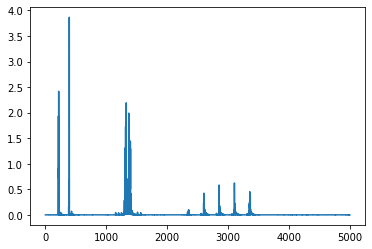

[1328  218  392]
[2.19185564 2.41795274 3.86612618]


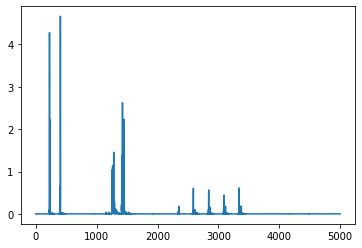

[1424  404  225]
[2.61988136 4.66072947 4.27627649]


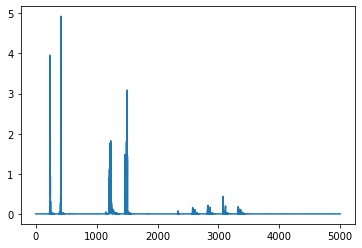

[1501  237  416]
[3.08360637 3.95533864 4.92575274]


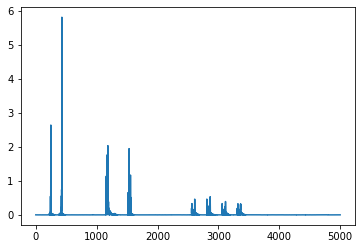

[246 247 428]
[2.30849988 2.64519237 5.81857012]


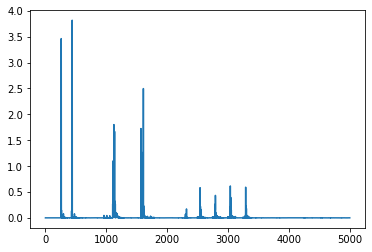

[1609  260  440]
[2.49750893 3.46244311 3.81696903]


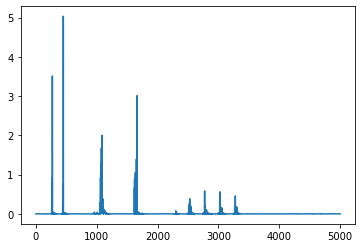

[1664  272  452]
[3.01140473 3.51117978 5.03435851]


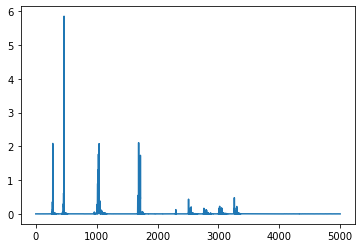

[ 279 1689  464]
[2.08467967 2.10693346 5.84839142]


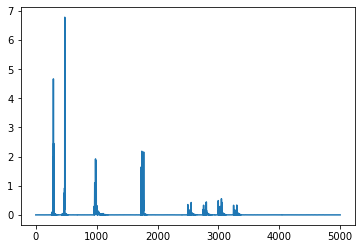

[293 476 289]
[2.45591106 6.77472164 4.66154217]


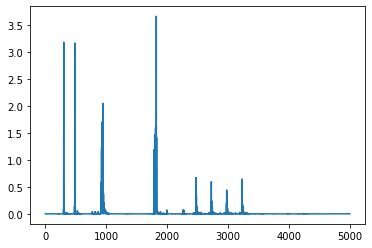

[ 488  301 1821]
[3.15922782 3.17536077 3.65620932]


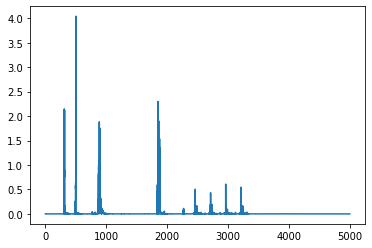

[ 310  500 1849]
[2.14673411 4.04108085 2.2980915 ]


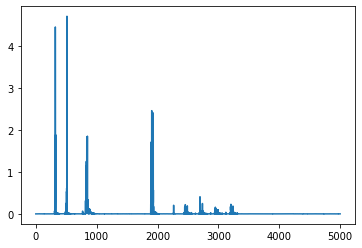

[1904  321  512]
[2.46456918 4.46020284 4.71626387]


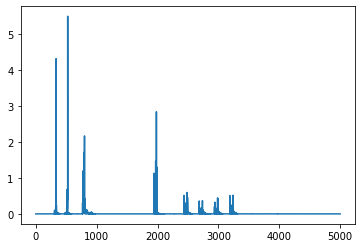

[1981  333  524]
[2.84247011 4.31762261 5.49802503]


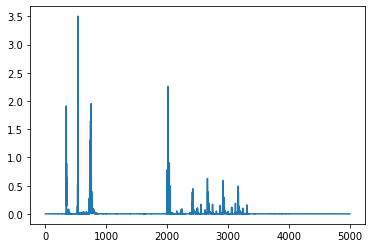

[ 752 2012  536]
[1.95427098 2.2594119  3.50204745]


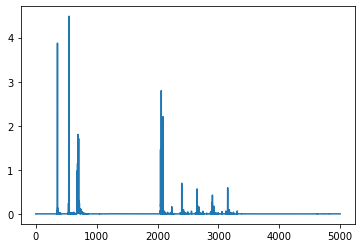

[2061  356  548]
[2.79659711 3.87454428 4.48376678]


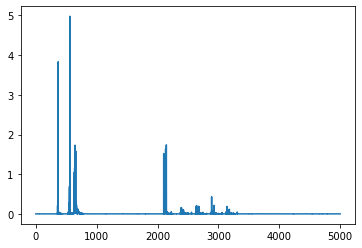

[2144  368  560]
[1.73934562 3.8339625  4.97991197]


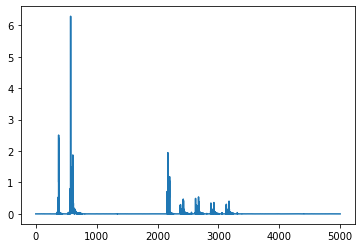

[377 375 572]
[2.40806188 2.50678963 6.28499495]
[392, 404, 416, 428, 440, 452, 464, 476, 1821, 500, 512, 524, 536, 548, 560, 572]


In [7]:
POIs = [0 for i in range(16)]
for nibble in range(16):
        POIs[nibble] = findPOI(nibble,"attack_on_other_nibbles/SNR_nibble"+str(nibble))
print(POIs)

In [8]:
POIs = [392, 404, 416, 428, 440, 452, 464, 476, 488, 500, 512, 524, 536, 548, 560, 572]

## Build templates for all nibbles

In [9]:
def build_template(POI,nibble):
    
    no_of_sets = 16 #for signal = identity, we group leakages into 16 sets
        
    #record leakages at the POI for traces in each set
    poi_leakage = [[] for x in range(no_of_sets)] 
    #separate leakages to sets depending on the Sbox output value and leakage model
    for j in range(file_no_rk): #for each plaintext in the profiling dataset
        iv = sbox_outputs[j][nibble]
        poi_leakage[iv].append(trace_array_rk[j,POI])
    
    #mean vectors
    mean_vector = []
    #variances
    variances = []
    for i in range(no_of_sets):
        mean_vector.append(statistics.mean(poi_leakage[i]))
#         variances.append(statistics.variance(poi_leakage[i]))
        variances.append(np.var(poi_leakage[i]))
    
    return mean_vector,variances

In [10]:
template_means = [[] for i in range(16)]
template_variance = [[] for i in range(16)]
for j in range(16):
    template_means[j], template_variance[j] =  build_template(POIs[j],j)

In [11]:
#templates for 1st nibble
for i in range(16):
    print("template for value " + str(i))
    print("mean" + str(template_means[1][i]) + ", variance " + str(template_variance[1][i]))

template for value 0
mean-0.03902745207993475, variance 2.164374658694695e-06
template for value 1
mean-0.0427254313973064, variance 2.1531920306603584e-06
template for value 2
mean-0.04283854166666667, variance 2.3259056939019095e-06
template for value 3
mean-0.04415295369601329, variance 2.1240387298041346e-06
template for value 4
mean-0.041221845004363, variance 2.0062919546453646e-06
template for value 5
mean-0.04542490794939577, variance 2.2319853379260917e-06
template for value 6
mean-0.04491877971473851, variance 2.0222031535222443e-06
template for value 7
mean-0.04816550925925926, variance 2.4035962684327845e-06
template for value 8
mean-0.04286745340356564, variance 1.980553455841333e-06
template for value 9
mean-0.04608543882978723, variance 2.407747859737644e-06
template for value 10
mean-0.045751723884976524, variance 2.235056596240688e-06
template for value 11
mean-0.049776829932646594, variance 2.2239602376368712e-06
template for value 12
mean-0.044396499515503875, varian

In [12]:
#templates for 2nd nibble
for i in range(16):
    print("template for value " + str(i))
    print("mean" + str(template_means[2][i]) + ", variance " + str(template_variance[2][i]))

template for value 0
mean-0.04534563621533442, variance 2.098043396846076e-06
template for value 1
mean-0.04906305277122641, variance 1.8866457972532775e-06
template for value 2
mean-0.05001461733678344, variance 2.311262050803387e-06
template for value 3
mean-0.05088420542635659, variance 2.0179911291905162e-06
template for value 4
mean-0.04775840868441971, variance 2.2140354792844277e-06
template for value 5
mean-0.05109831574675325, variance 2.159801295925944e-06
template for value 6
mean-0.05227392325129534, variance 1.7859236444564088e-06
template for value 7
mean-0.054491579996111976, variance 2.1878441995505146e-06
template for value 8
mean-0.049414707095709574, variance 2.098334875789172e-06
template for value 9
mean-0.05225078876201923, variance 1.9867994493751596e-06
template for value 10
mean-0.05330594168060201, variance 2.113314379293768e-06
template for value 11
mean-0.05618978628716745, variance 2.329428828941702e-06
template for value 12
mean-0.05095608618951613, varian

## Attack

In [13]:
#We first load data from the "random plaintext dataset", this set of traces will be used for our attack
file_no = 5000
traces = []
plaintexts = []

for i in range(file_no):
    with open(attack_trace_folder + 'trace_'+str(i)+'.txt') as f:
        lines = f.read().splitlines()
        traces.append(lines)

with open(attack_trace_folder + 'plaintexts.txt') as f:
    plaintexts = f.read().splitlines()
    
trace_array = np.array(traces)
trace_array = trace_array.astype(float)

plaintext_array = np.array(plaintexts)

In [14]:
#the correct key FEDCBA0123456789
round_key = [15,14,13,12,11,10,0,1,2,3,4,5,6,7,8,9]

In [15]:
#compute probability scores for each key hypothesis
#mean and variances are the templates
def prob_score(max_no_trace, nibble):
    key_nibble = round_key[15-nibble]
    print("correct key nibble is " + str(key_nibble))
    #template mean for the target nibble
    mean_vector = template_means[nibble]
    #template variance for the target nibble
    variances = template_variance[nibble]
    POI = POIs[nibble]
    #probability score for all key hypotheses
    all_prob_score = [[0 for x in range(max_no_trace+1)] for y in range(16)]
    for no_of_traces in range(1,max_no_trace+1):
        ind = [i for i in range(no_of_traces)]
        traces = trace_array[ind]
        pts = plaintext_array[ind]
        
        prob = [0 for x in range(16)]#score for each key hypothesis
    
        #group the traces according to the key hypothesis
        for k in range(16): #for each key hypothesis
            #compute score of each trace
            for j in range(no_of_traces): #for each trace
                pt = int(pts[j][15-nibble],16) # get the target nibble of the plaintext
                iv = S[k^pt] #compute the intermediate value
                trace_leakage = traces[j,POI]
                #compute the score of this trace using the template
                mean_dif = trace_leakage-mean_vector[iv]
                trace_prob = math.log(variances[iv])+(mean_dif*mean_dif)/variances[iv]
                #probablity for each key hypothesis is update with each trace
                prob[k] -= trace_prob
                
        for k in range(16):
            all_prob_score[k][no_of_traces] = prob[k]
    
    #plot probability scores
    x = []
    for no_of_traces in range(max_no_trace+1):
        x.append(no_of_traces)
    for k in range(16):
        if k == key_nibble:
            plt.plot(x,all_prob_score[k],'b')
        else:
            plt.plot(x,all_prob_score[k],color="#808080")
    plt.title('Probability scores')
    plt.show()
    
    #save to file
    for k in range(16):
        filename = "attack_on_other_nibbles/nibble" + str(nibble) + "key" + str(k)
        savetofile(filename,all_prob_score[k])
    return

nibble0
correct key nibble is 9


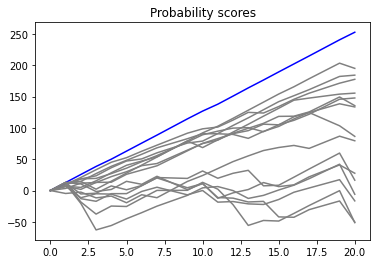

nibble1
correct key nibble is 8


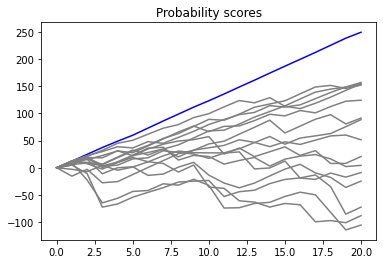

nibble2
correct key nibble is 7


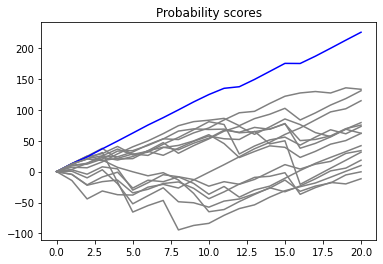

nibble3
correct key nibble is 6


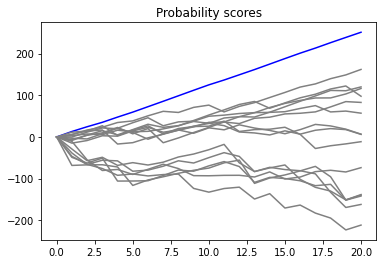

nibble4
correct key nibble is 5


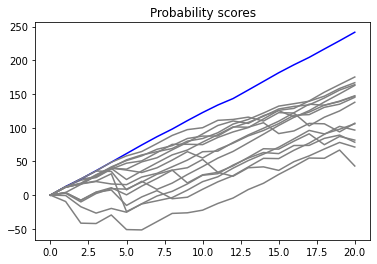

nibble5
correct key nibble is 4


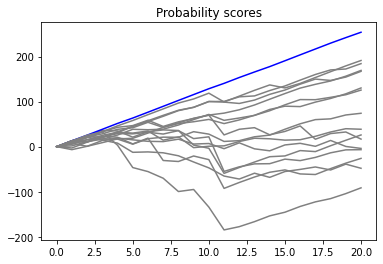

nibble6
correct key nibble is 3


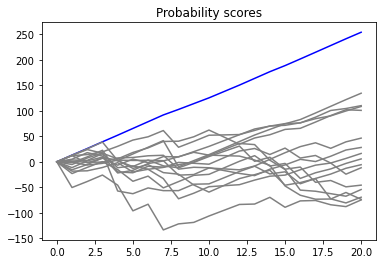

nibble7
correct key nibble is 2


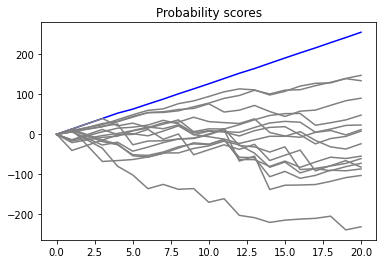

nibble8
correct key nibble is 1


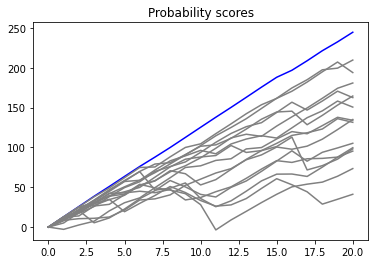

nibble9
correct key nibble is 0


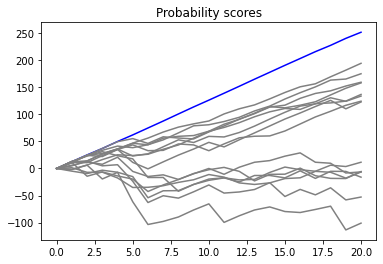

nibble10
correct key nibble is 10


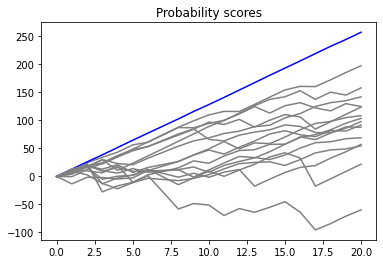

nibble11
correct key nibble is 11


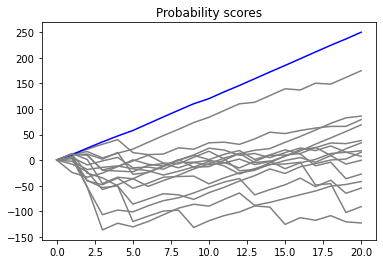

nibble12
correct key nibble is 12


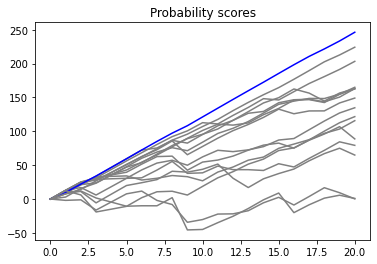

nibble13
correct key nibble is 13


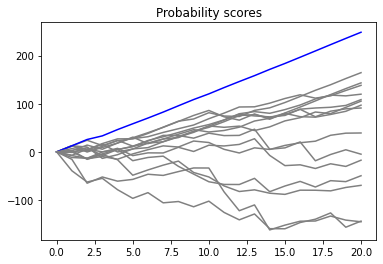

nibble14
correct key nibble is 14


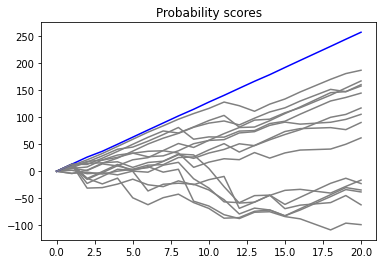

nibble15
correct key nibble is 15


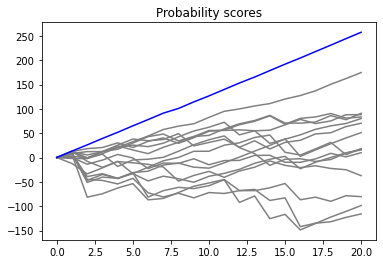

In [16]:
for i in range(16):
    print("nibble" + str(i))
    prob_score(20, i)